In [2]:
import os
from pyrsgis import raster
from sklearn import cluster
from osgeo import gdal
import geopandas as gdp
import pandas as pd
import numpy as np
import rasterio as rio
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt
from glob import glob
from rasterio.plot import show
import pandas as pd
import cv2

Warning! matplotlib_scalebar library not found.


**Group Members:** <br><br> Luis Garcia <br> Caleb Roudy <br> Rowan Beswick

# Introduction
**The 2019 to 2020 Australian bushfire season, also known as Black summer, was one of the worst natural disasters in modern history. Not only causing havic within some on the wider ecosystem in central- southern Australia, but also affecting human society. By the end of it all, more than 9,000 buildings were vanquished, along with 34 unfortunate lives lost.These damages can be assessed from above with the many commericial domestic and international satelittes and platforms. One of the more prominent platforms from above is Landsat 8, which has been around monitoring most portions of the globe. The images from the satelitte are utilized to monitor and detect surface processes such as wildfire, ice melt, deforestation, as well as others. 
# Methods

Data used entails (band 1 — band 7) of Landsat 8/OLI Sydney fire as features  and try to predict the binary fire/nonfire class. These 2 images will be used for training and testing. Finally, another multispectral Landsat 8 data acquired in the  the outside of Newcastle( rural town of Murrurundi)  will be used for new predictions. To further prove the effiency o this method, a California fire image will also. Lastly, a Desicion Tree method will also be implemented on the California Fire.

**Portions of the electromagnetic spectrum that Landsat 8/OLI covers**
![image](https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/dmidS2LS7Comparison.png)
This is a graph showing the different ranges and disributions of the electromagnetic spectrum at which each sensors covers. Most areas at which they cover were designed to capture solar radiation signal from the so called "Atmosphereic Window" <br><BR>
<i> Source </i>: https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/dmidS2LS7Comparison.png 

In [2]:
# Path of the file we will be using to idenitfy fire

# Image of the fire in Newcastle( rural town of Murrurundi)
landsat_path = glob("LC08_L1TP_090082_20191231_20200111_01_T1/LC08_L1TP_090082_20191231_20200111_01_T1_B*.TIF")
landsat_path.sort()
array_stack, meta_data = es.stack(landsat_path)

# Image of the fire in the outskirts of Sydney, Australia
landsat_path_2 = glob("LC08_L1TP_090083_20191215_20191226_01_T1/LC08_L1TP_090083_20191215_20191226_01_T1_B*_Refl.TIF")
landsat_path_2.sort()
array_stack_2, meta_data_2 = es.stack(landsat_path_2)


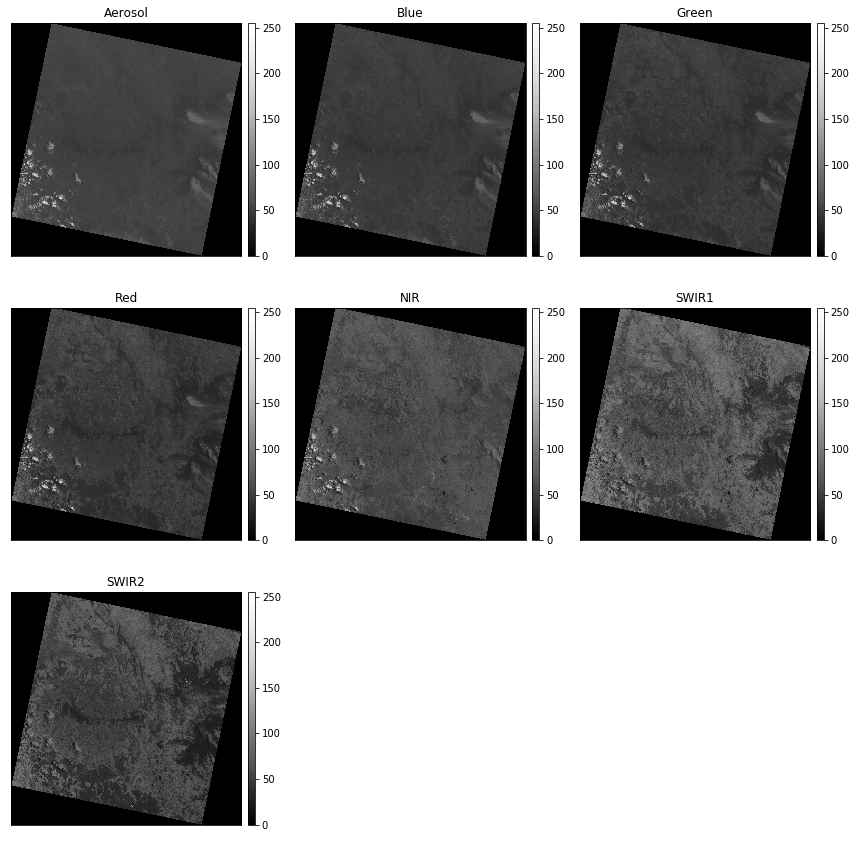

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002518571B148>,
      dtype=object)

In [3]:
title = ['Aerosol' , 'Blue' , 'Green' , 'Red' , 'NIR' , 'SWIR1' , 'SWIR2']

ep.plot_bands(array_stack,
              title=title)

<IPython.core.display.Javascript object>


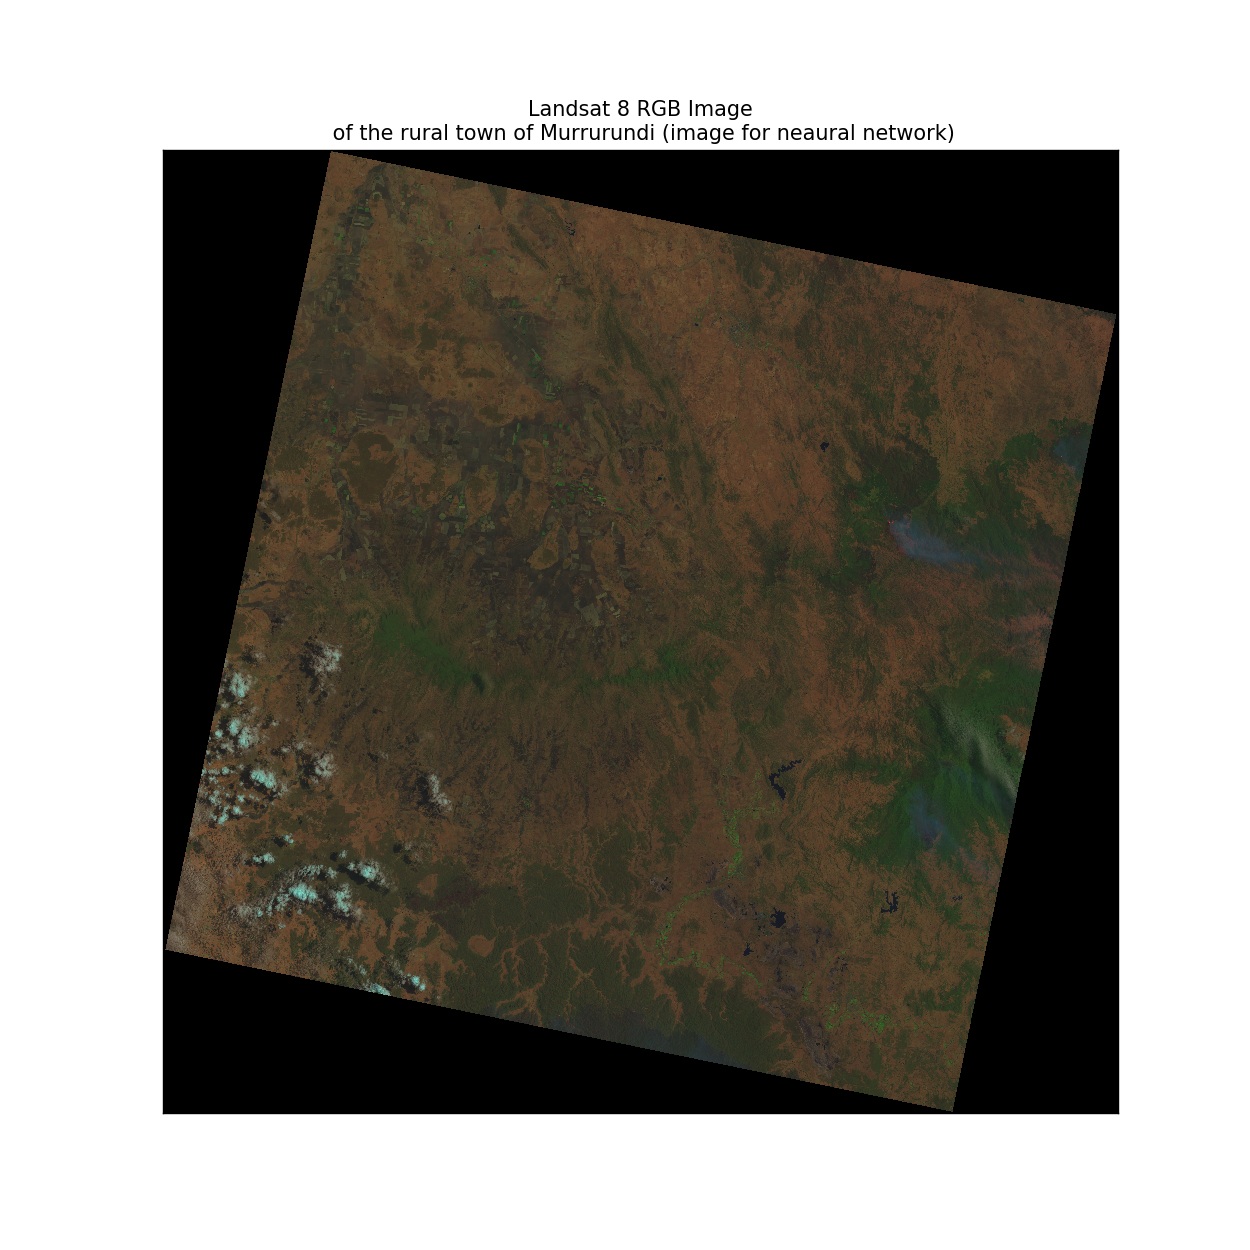

<IPython.core.display.Javascript object>


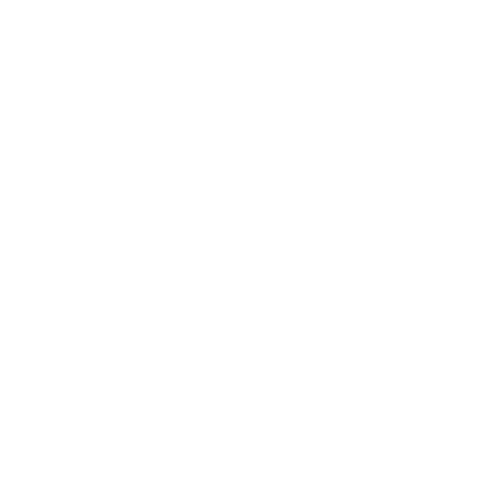

<IPython.core.display.Javascript object>


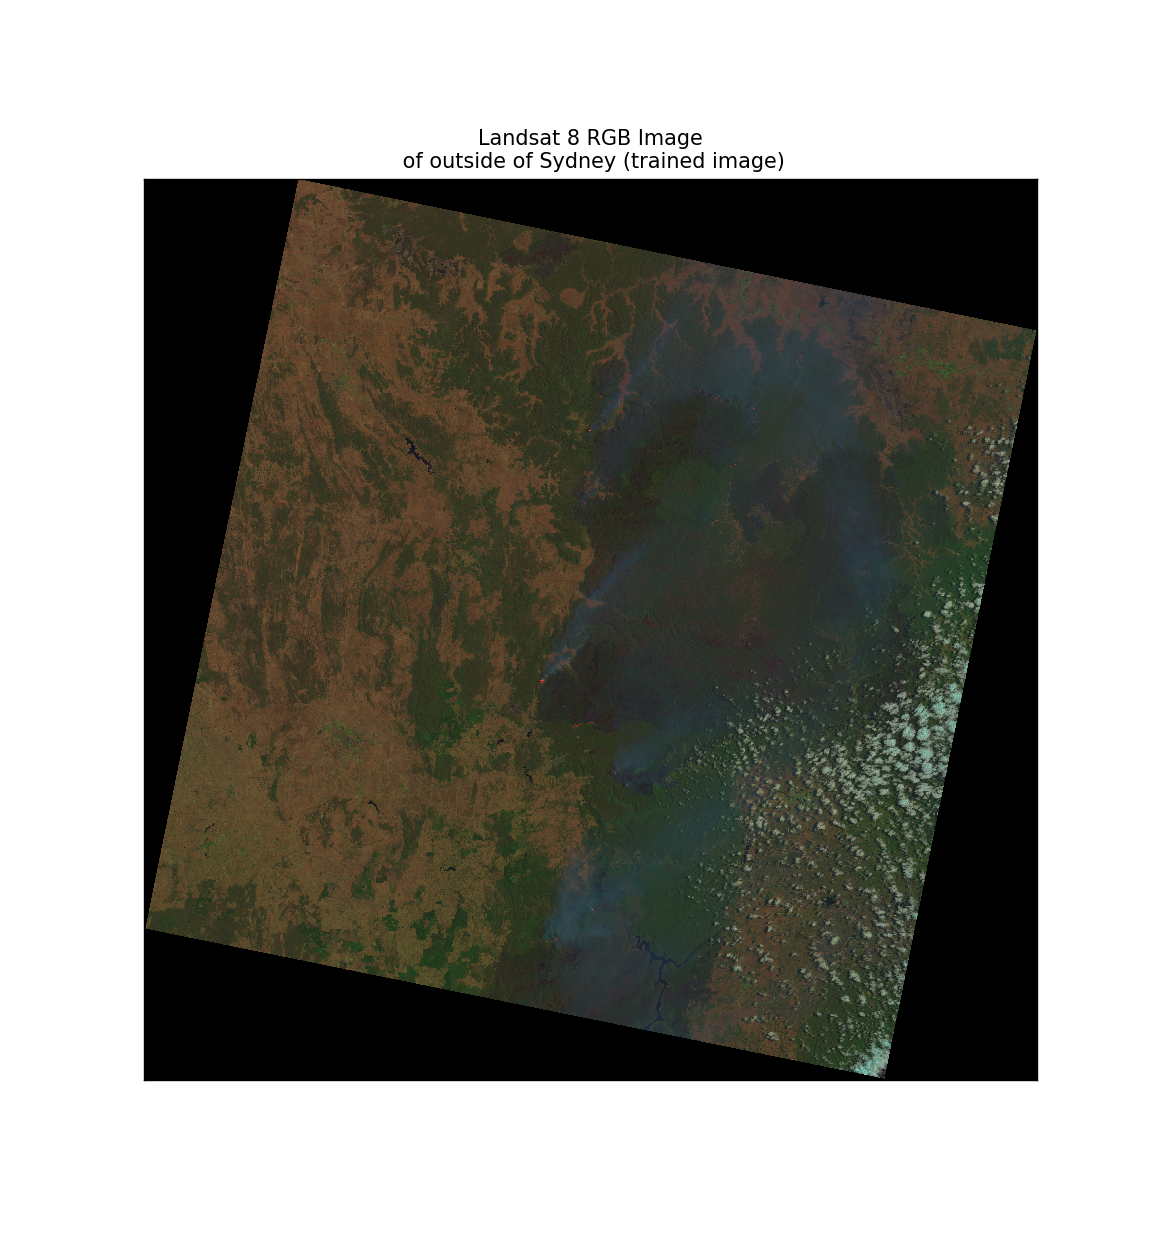

<IPython.core.display.Javascript object>


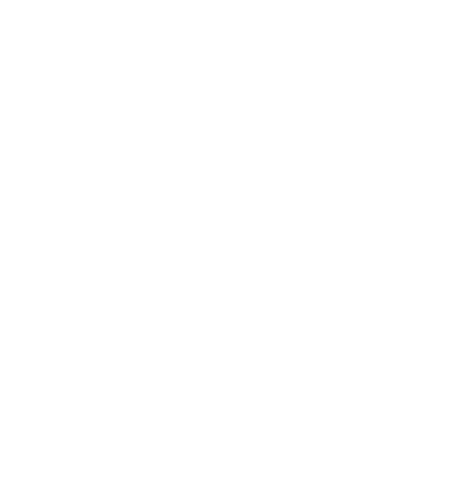

<IPython.core.display.Javascript object>


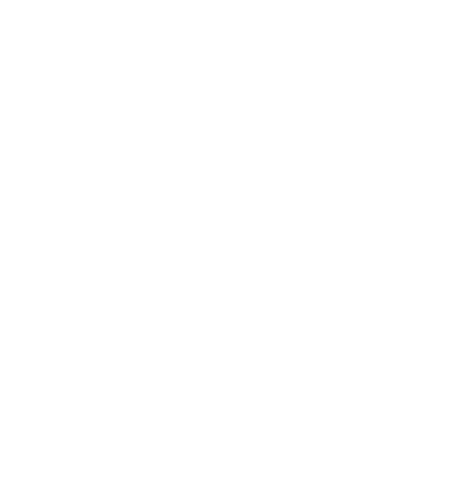

In [12]:
%matplotlib notebook
# Tr
ep.plot_rgb(array_stack,
            rgb=[5, 4, 2],
            title="Landsat 8 RGB Image\n of the rural town of Murrurundi (image for neaural network)")
plt.figure(figsize=(4,4))

# Adjust the amount of linear stretch to futher brighten the image
ep.plot_rgb(array_stack_2,
            rgb=[5, 4, 2],
            title="Landsat 8 RGB Image\n of outside of Sydney (trained image)")
plt.figure(figsize=(4,4))


**Up above are images utilizing the portions of the electromagnetic spectrum that Landsat 8 covers. Notice how cloud/smoke cover dissapates as electromagnetic spectrum shifts to longer wavelengths. This process is explained by the scattering proporties of particles in our atmosphere.**
<br> The second set of images here are true color composites, using blue, green, red bands of the spectrum

**K Means Cluster; finding ideal number of clusters that the data naturally binds to:**

Text(0, 0.5, 'Sum of squared distance')

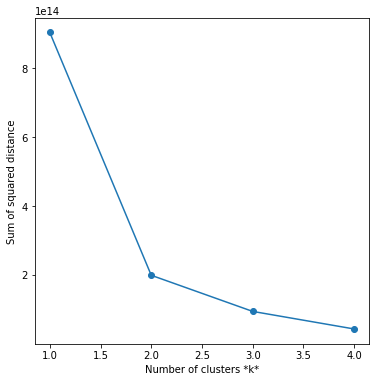

In [6]:
# Run the Kmeans algorithm and get the index of data points clusters
file = 'LC08_L1TP_044032_20181108_20181116_01_T1.tar/LC08_L1TP_044032_20181108_20181116_01_T1/LC08_L1TP_044032_20181108_20181116_01_T1_B7.tif'

dataset = gdal.Open(file)
Band= dataset.GetRasterBand(1)
img = Band.ReadAsArray()
X = img.reshape((-1,1))

sse = []
list_k = list(range(1, 5))

for k in list_k:
    km =cluster.KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)


# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

# Neural Network Classification
This diagram illustrates the theory behind neural netoworks for detecton. In short, features, or bands of an image in this case, are put into the network, as well as a true label of those bands, and ultimately outputs a final map

<img src = "Neural Network Design.jpg">

In [3]:
# Landsat 8/OLI image of Outside of Sydney
southerAus = 'LC08_L1TP_090083_20191215_20191226_01_T1/LC08_20191215_1226_LayersStacked_ALL.tif' 
# 'LC08_L1TP_090083_20191215_20191226_01_T1/LC08_20191215_1226_LayersStacked_ALL.tif'

# Binary Classification of fire non fire ground truth of Sydney (produced from K-means)
fire_Binary = 'LC08_L1TP_090083_20191215_20191226_01_T1_NEW/min_distance_fire_nonfire.tif' 

# Outside of Newcastle in the rural town of Murrurundi 
eastAus = 'LC08_L1TP_090082_20191231_20200111_01_T1/LC08_20191231_20200111_01_T1_Stacked.tif' 

#LC08_L1TP_091086_20191222_20200110_01_T1 (Victoria, Australia- outside of the town of Bumberrah)

# Read the rasters as array
ds7, featuresSouthAus = raster.read(southerAus, bands='all')
ds6, labelsAus = raster.read(fire_Binary, bands=1)
ds5, featuresEastAus = raster.read(eastAus, bands='all')

In [13]:
print("Fire b7 image shape: ", featuresSouthAus.shape)
print("Fire b6 image shape: ", labelsAus.shape)
print("Fire b5 image shape: ", featuresEastAus.shape)

Fire b7 image shape:  (7, 7691, 7621)
Fire b6 image shape:  (7691, 7621)
Fire b5 image shape:  (7, 7701, 7641)


In [4]:
from pyrsgis.convert import changeDimension

featuresSouthAus = changeDimension(featuresSouthAus)
labelsAus  = changeDimension(labelsAus)
featuresEastAus = changeDimension(featuresEastAus)
nBands = featuresSouthAus.shape[1]
labelsAus= (labelsAus == 1).astype(int)

print("Souther Aus multispectral image shape: ", featuresSouthAus.shape)
print("Southern Aus Fire/nonFire binary shape: ", labelsAus.shape)
print("Victoria multispectral image shape: ", featuresEastAus.shape)

Souther Aus multispectral image shape:  (58613111, 7)
Southern Aus Fire/nonFire binary shape:  (58613111,)
Victoria multispectral image shape:  (58843341, 7)


In [6]:
from sklearn.model_selection import train_test_split

                              #X (Indepent Varibles/Data)  #y(Dependent/Labels (Fire/NonFire))
xTrain, xTest, yTrain, yTest = train_test_split(featuresSouthAus, labelsAus, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(35167866, 7)
(35167866,)
(23445245, 7)
(23445245,)


In [7]:
# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))
featuresEastAus = featuresEastAus.reshape((featuresEastAus.shape[0], 1, featuresEastAus.shape[1]))

# Print the shape of reshaped data
print(xTrain.shape, xTest.shape, featuresEastAus.shape)



(35167866, 1, 7) (23445245, 1, 7) (58843341, 1, 7)


In [8]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=2)

Train on 35167866 samples
Epoch 1/2
35167866/35167866 [==============================] - 1111s 32us/sample - loss: 0.3852 - accuracy: 0.9999
Epoch 2/2
35167866/35167866 [==============================] - 921s 26us/sample - loss: 0.0028 - accuracy: 0.9999


In [15]:
np.unique(xTest)

array([    0,   968,  4436, ..., 65531, 65533, 65535])

In [12]:
yTestPredicted = model.predict(xTest)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [13]:
np.unique(yTestPredicted)

array([0.00000000e+00, 1.43727778e-38, 1.76250865e-38, 2.22284094e-38,
       2.30213187e-38, 3.11031394e-38, 3.34968403e-38, 3.91820931e-38,
       3.98203818e-38, 4.21756702e-38, 4.37972472e-38, 4.57770717e-38,
       9.83168267e-38, 1.06747957e-37, 1.27007404e-37, 1.47308676e-37,
       1.70485177e-37, 1.83511939e-37, 2.01736106e-37, 3.93437256e-37,
       4.01647296e-37, 4.06291894e-37, 5.71950170e-37, 5.86049833e-37,
       6.36379183e-37, 6.63671185e-37, 7.25194914e-37, 7.85146319e-37,
       8.51033624e-37, 1.12532257e-36, 1.40030478e-36, 1.85312193e-36,
       1.96809836e-36, 2.06000165e-36, 2.75138644e-36, 2.99415358e-36,
       3.32047702e-36, 3.54259337e-36, 4.12480961e-36, 5.50289091e-36,
       6.55922045e-36, 6.78858247e-36, 7.43767504e-36, 8.17592194e-36,
       9.59676343e-36, 1.14824934e-35, 1.34008580e-35, 1.42146195e-35,
       1.67439341e-35, 2.13171926e-35, 2.80185708e-35, 3.12674724e-35,
       7.20387134e-35, 8.80437348e-35, 9.89985501e-35, 1.00985009e-34,
      

In [20]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict for test data 
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

print("Confusion matrix: for 14 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Confusion matrix: for 14 nodes
 [[23438087     2235]
 [      24     4899]]

P-Score: 0.687, R-Score: 0.995


In [26]:
landsat_path = glob("LC08_L1TP_090082_20191231_20200111_01_T1/LC08_L1TP_090082_20191231_20200111_01_T1_B*.TIF")
landsat_path.sort()
array_stack, meta_data = es.stack(landsat_path)

print(len(landsat_path))

7


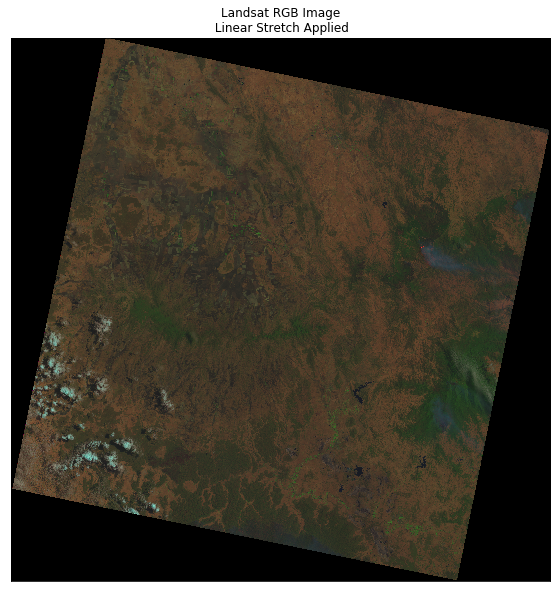

In [28]:
# Adjust the amount of linear stretch to futher brighten the image

ep.plot_rgb(array_stack,
            rgb=[5, 4, 2],
            title="Landsat RGB Image\n Linear Stretch Applied")
plt.show()

In [24]:
predicted = model.predict(featuresEastAus)
predicted = predicted[:,1]
#Export raster
prediction = np.reshape(predicted, (ds5.RasterYSize, ds5.RasterXSize))
outFile = 'Eastern Australia Fire Prediction.tif'
raster.export(prediction, ds5, filename=outFile, dtype='float')

# Final output

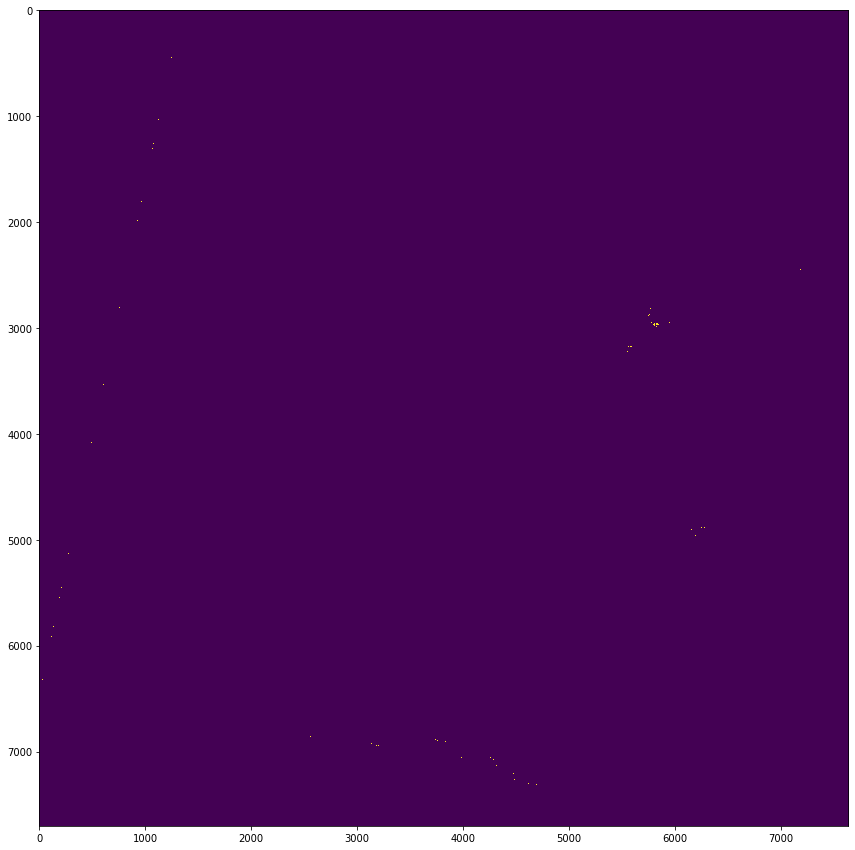

In [41]:
# Read File Raster Data as Array using Gdal
img_file = "Eastern Australia Fire Prediction.tif"
gtif = gdal.Open(img_file)
georaster = gtif.ReadAsArray()

 # Plot image using matplotlib
plt.figure(figsize=(10,10))
plt.imshow(georaster)

# Demonstration 2

In [41]:
# Landsat 8/OLI image of Outside of Sydney
southerAus = 'LC08_L1TP_090083_20191215_20191226_01_T1/LC08_20191215_1226_LayersStacked_ALL.tif' 
# 'LC08_L1TP_090083_20191215_20191226_01_T1/LC08_20191215_1226_LayersStacked_ALL.tif'

# Binary Classification of fire non fire ground truth of Sydney (produced from K-means)
fire_Binary = 'LC08_L1TP_090083_20191215_20191226_01_T1_NEW/min_distance_fire_nonfire.tif' 

# Outside of Newcastle in the rural town of Murrurundi 
cal_fire = 'LC08_L1TP_044032_20181108_20181116_01_T1.tar/LC08_L1TP_044032_20181108_20181116_01_T1/LC08_L1TP_044032_20181108_20181116_01_T1_LayerStacked.tif' 

#LC08_L1TP_091086_20191222_20200110_01_T1 (Victoria, Australia- outside of the town of Bumberrah)

# Read the rasters as array
ds1, ftSouthAus = raster.read(southerAus, bands='all')
ds2, labelsAus = raster.read(fire_Binary, bands=1)
ds3, ftCal = raster.read(cal_fire, bands='all')

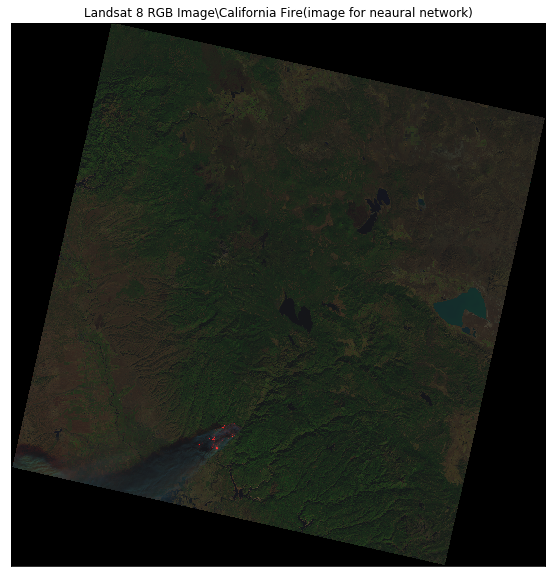

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [33]:
landsat_path_3 = glob("LC08_L1TP_044032_20181108_20181116_01_T1.tar/LC08_L1TP_044032_20181108_20181116_01_T1/LC08_L1TP_044032_20181108_20181116_01_T1_B*.TIF")
landsat_path_3.sort()
array_stack_3, meta_data_3 = es.stack(landsat_path_3)

ep.plot_rgb(array_stack_3,
            rgb=[5, 4, 2],
            title="Landsat 8 RGB Image\California Fire(image for neaural network)")
plt.figure(figsize=(4,4))

In [43]:
print("Fire b7 image shape: ", ftSouthAus.shape)
print("Fire b6 image shape: ", labelsAus.shape)
print("Fire b5 image shape: ", ftCal.shape)

Fire b7 image shape:  (7, 7691, 7621)
Fire b6 image shape:  (7691, 7621)
Fire b5 image shape:  (7, 7781, 7651)


In [44]:
from pyrsgis.convert import changeDimension

ftSouthAus = changeDimension(ftSouthAus)
labelsAus = changeDimension(labelsAus)
ftCal = changeDimension(ftCal)
nBands = ftSouthAus.shape[1]
labelsAus= (labelsAus == 1).astype(int)

print("Souther Aus multispectral image shape: ", ftSouthAus.shape)
print("Southern Aus Fire/nonFire binary shape: ", labelsAus.shape)
print("California FIre multispectral image shape: ", ftCal.shape)

Souther Aus multispectral image shape:  (58613111, 7)
Southern Aus Fire/nonFire binary shape:  (58613111,)
California FIre multispectral image shape:  (59532431, 7)


In [45]:
from sklearn.model_selection import train_test_split

                              #X (Indepent Varibles/Data)  #y(Dependent/Labels (Fire/NonFire))
xTrain, xTest, yTrain, yTest = train_test_split(ftSouthAus, labelsAus, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(35167866, 7)
(35167866,)
(23445245, 7)
(23445245,)


In [46]:
# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))
ftCal= ftCal.reshape((ftCal.shape[0], 1, ftCal.shape[1]))

# Print the shape of reshaped data
print(xTrain.shape, xTest.shape, ftCal.shape)



(35167866, 1, 7) (23445245, 1, 7) (59532431, 1, 7)


In [47]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=2)

Train on 35167866 samples
Epoch 1/2
35167866/35167866 [==============================] - 925s 26us/sample - loss: 0.0542 - accuracy: 1.0000
Epoch 2/2
35167866/35167866 [==============================] - 924s 26us/sample - loss: 0.0013 - accuracy: 1.0000


In [48]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict for test data 
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

print("Confusion matrix: for 14 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Confusion matrix: for 14 nodes
 [[23438509     1813]
 [      31     4892]]

P-Score: 0.730, R-Score: 0.994


In [49]:
predicted = model.predict(ftCal)
predicted = predicted[:,1]
#Export raster
prediction = np.reshape(predicted, (ds3.RasterYSize, ds3.RasterXSize))
outFile = 'California Fire Prediction.tif'
raster.export(prediction, ds3, filename=outFile, dtype='float')

# Output #2

<IPython.core.display.Javascript object>


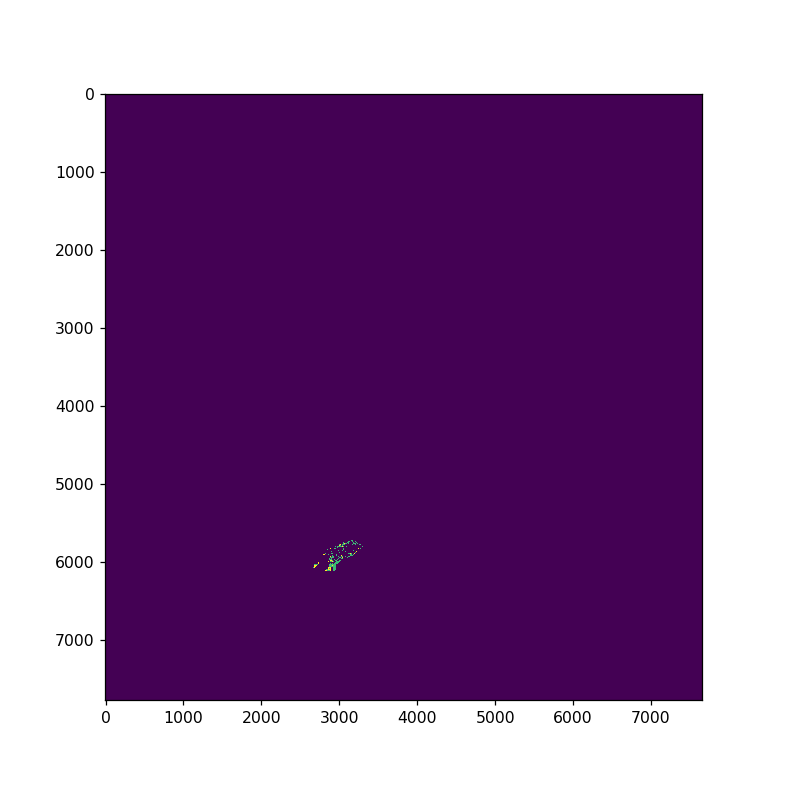

In [59]:

img_file = "California Fire Prediction.tif"
gtif = gdal.Open(img_file)
georaster = gtif.ReadAsArray()    
plt.figure(figsize=(7,7))
plt.imshow(georaster)

# Decision Trees Classifier Method

In [1]:
from sklearn import cluster
from osgeo import gdal
import geopandas as gdp
import pandas as pd
import numpy as np
import rasterio as rio
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import os
import matplotlib.pyplot as plt
from glob import glob
from rasterio.plot import show
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree

In [ ]:
# load in all videos    
dispids = ['LC08_L1TP_043035_20160823_20170223_01_T1_','LC08_L1TP_044035_20160830_20170221_01_T1_',
           'LC08_L1TP_090084_20191231_20200111_01_T1_','LC08_L1TP_090084_20191215_20191226_01_T1_',
           'LC08_L1TP_091083_20191206_20191217_01_T1_','LC08_L1TP_090086_20191231_20200111_01_T1_']
dispidstest = ['LC08_L1TP_090083_20191215_20191226_01_T1_','LC08_L1TP_044033_20181108_20181116_01_T1_',
               'LC08_L1TP_044032_20181108_20181116_01_T1_']
bandsused = ['B6','B7']
exttarg = 'BT'
path = 'Caleb_Extracted_Images/'
exten = '.tif'

alltb = []
all6 = []
all7 = []

for ids in dispids:
    strt = path+ids+exttarg+exten
    print(strt)
    datatarg = gdal.Open(strt)
    bandtarg = datatarg.GetRasterBand(1)
    imgtarg = bandtarg.ReadAsArray()
    alltb.append(imgtarg>0)

    str6 = path+ids+bandsused[0]+exten
    dataset6 = gdal.Open(str6)
    Band6 = dataset6.GetRasterBand(1)
    img6 = Band6.ReadAsArray()
    all6.append(img6)
    
    str7 = path+ids+bandsused[1]+exten
    dataset7 = gdal.Open(str7)
    Band7 = dataset7.GetRasterBand(1)
    img7 = Band7.ReadAsArray()
    all7.append(img7)
    using
del strt, datatarg, bandtarg, imgtarg, dispids, str6, dataset6, Band6, img6, str7, dataset7, Band7, img7

In [ ]:

# find max array length
max_len = max(len(item.reshape(-1,1)) for item in all6)
# concatenate inputs and reshape variables
allts = []
for arr in alltb:
    vec = arr.reshape(-1,1)
    if len(vec) < max_len:
        vec = np.append(vec,np.zeros((max_len - len(vec)),dtype=bool)) 
    else:
        vec = vec[:].transpose(1,0).reshape(len(vec),)
    allts.append(vec)
allts = np.stack(allts,axis=0)
allts = allts.reshape(len(allts)*len(allts[0]),)

all6s = []
for arr in all6:
    vec = arr.reshape(-1,1)
    if len(vec) < max_len:
        vec = np.append(vec,np.zeros((max_len - len(vec)))) 
    else:
        vec = vec[:].transpose(1,0).reshape(len(vec),)
    all6s.append(vec)
all6s = np.stack(all6s,axis=0)
all6s = all6s.reshape(len(all6s)*len(all6s[0]),)

all7s = []
for arr in all7:
    vec = arr.reshape(-1,1)
    if len(vec) < max_len:
        vec = np.append(vec,np.zeros((max_len - len(vec)))) 
    else:
        vec = vec[:].transpose(1,0).reshape(len(vec),)
    all7s.append(vec)
all7s = np.stack(all7s,axis=0)
all7s = all7s.reshape(len(all7s)*len(all7s[0]),)

allin = np.stack([all6s,all7s])
print(allin)

del alltb, all6, all7, vec, all6s, all7s

<img src= "Final Project Caleb Images/first_output_3.png">


allin = np.transpose(allin)
print(allin)

<img src= "Final Project Caleb Images/second_output_2.png">

In [ ]:
# separate training and testing data
XTrain, XTest, yTrain, yTest = train_test_split(allin, allts, random_state=1, test_size=0.5)
decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

<img src = "Final Project Caleb Images/third_output_3.png">

In [ ]:
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

<img src = "Final Project Caleb Images/fourth_output_2.png">

In [ ]:
del XTrain, XTest, yTrain, yTest, allin, allts, y_pred_train, y_pred

In [ ]:
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

colorext = ['B2','B3','B4'] # blue, green, red in order

str2 = path+dispidstest[2]+colorext[0]+exten
dataset2 = gdal.Open(str2)
Band2 = dataset2.GetRasterBand(1)
img2 = Band2.ReadAsArray()

str3 = path+dispidstest[2]+colorext[1]+exten
dataset3 = gdal.Open(str3)
Band3 = dataset3.GetRasterBand(1)
img3 = Band3.ReadAsArray()

str4 = path+dispidstest[2]+colorext[2]+exten
dataset4 = gdal.Open(str4)
Band4 = dataset4.GetRasterBand(1)
img4 = Band4.ReadAsArray()

img2n = normalize(img2)
img3n = normalize(img3)
img4n = normalize(img4)
imgcolor = np.dstack((img2n, img3n, img4n))

str6 = path+dispidstest[2]+bandsused[0]+exten
dataset6 = gdal.Open(str6)
Band6 = dataset6.GetRasterBand(1)
img6 = Band6.ReadAsArray()
img6 = img6.reshape(-1,1)
    
str7 = path+dispidstest[2]+bandsused[1]+exten
dataset7 = gdal.Open(str7)
Band7 = dataset7.GetRasterBand(1)
img7 = Band7.ReadAsArray()
img7 = img7.reshape(-1,1)

img67 = np.stack([img6,img7])
img67 = np.transpose(img67)
img67 = img67.reshape(len(img6),2)

targ_pred = decisionTree.predict(img67)
targ_pred = targ_pred.reshape(np.shape(img2))

del img2, img3, img4, img6, img7, img67, str2, str3, str4, str6, str7, dataset2, dataset3, dataset4, dataset6, dataset7
del Band2, Band3, Band4, Band6, Band

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(imgcolor)
plt.show()

<img src = "Final Project Caleb Images/Cal_Fire.png">

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(targ_pred)
plt.show()

<img src = "Final Project Caleb Images/DecisionTree_Output.png">

In [ ]:

imgcolor[targ_pred] = 1
plt.figure(figsize=(20,20))
plt.imshow(imgcolor)
plt.show()

<img src = "Final Project Caleb Images/Overlay.png">

# Ethical Considerations – post project completion

The ethical considerations in this project can be quite extensive depending on the use of its work. We scraped our data from 
EarthExplorer’s API. For the scope of this project we haven’t pulled large amounts of files as each one requires a lot of processing to
analyse. However if scaled up, some people may find it intrusive that you are collecting images of private property, and methods should
be implemented into taking away images if requested by individuals.

People relevant to the project include the local communities and services that could benefit from the work (e.g. firefighting services).
Given the focus of the project, it aligns quite well with their goals as well. It could provide useful information and protect local
communities. It can also be used as a quick alarm system to quickly alert local communities of danger.

If this project were to be extended, it could be set up to alert any nearby homes if it detects fire or connected to a text alert system
in place. For this, a very high level of accuracy would need to be achieved as it could send out false alarms or even worse, not detect
fire when it is present. 

Another useful aspect to add that should be consider if the project were to be extended is furthering both models by using highlighy temporal resolution data to monitor fires in a more interactive manner. Perhaps seeing the general direction of a fire within an hour.

The biggest thing that should be taken away by the audience is that given a project of this magnitude, it is recommended to test a classification or theory in smaller portions, instead of trying to go through a lot of images, unless the data is constinetly efficient. Problems like this are invetiable with satelitte data. 